<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/hypertune_rf_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

---



In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle


In [24]:
! pip install bravado

     |████████████████████████████████| 133kB 15.0MB/s 
     |████████████████████████████████| 71kB 19.9MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=fbf6c7cdb4b3dc1fe0c6f2b1b2da9359183de3eedacc60697565e3c6b2a65ee4
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [25]:
#! time conda install -c conda-forge -y mordred bravado molvs
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [26]:
! wget https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df_1.csv

--2021-04-08 18:36:09--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/data/curated_combined_df_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541554 (529K) [text/plain]
Saving to: ‘curated_combined_df_1.csv.1’

curated_combined_df 100%[===================>] 528.86K  --.-KB/s    in 0.03s   

2021-04-08 18:36:09 (18.9 MB/s) - ‘curated_combined_df_1.csv.1’ saved [541554/541554]



In [27]:
import pandas as pd
df = pd.read_csv('curated_combined_df_1.csv', index_col=0)
df

,compound_id,base_rdkit_smiles,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,PXC50
0,CHEMBL599233,CC(C(=O)c1cccc([N+](=O)[O-])c1)N1CCCCC1,0,5.000000,0.000000,0.000000,0,5.000000
1,CHEMBL2047573,OC(CCN1CCC(O)(Cc2ccccc2)CC1)c1ccc(Cl)c(Cl)c1,1,6.249574,0.000738,0.013645,0,6.248721
2,CHEMBL1083410,CNC[C@H](O)CCN1c2ccccc2N(c2ccccc2F)S1(=O)=O,0,5.619388,0.001060,0.021791,0,5.618163
3,CHEMBL3673162,COc1ccc(-c2ccc3c(c2)CN2CCC3(c3ccc(Cl)c(Cl)c3)C...,1,8.229574,0.000602,0.005177,0,8.229148
4,CHEMBL2096860,COC(=O)[C@H]1C2CCC(C[C@@H]1c1ccc(I)cc1)N2C,1,7.642648,0.002293,0.017351,0,7.643974
...,...,...,...,...,...,...,...,...
5471,CHEMBL218952,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.700000,NaN,0.000000,0,3.700000
5472,CHEMBL3143431,CC[C@H](C)[C@H](NC(=O)[C@@H](NC[C@H](CC(C)C)NC...,1,8.100000,NaN,0.000000,0,8.100000
5473,CHEMBL411570,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.740000,NaN,0.000000,0,3.740000
5474,CHEMBL383931,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...,0,3.760000,NaN,0.000000,0,3.760000


In [28]:
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')

,compound_id,base_rdkit_smiles,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,PXC50


In [29]:
print('the min value to label active is:',min(df.loc[df.active==1]['VALUE_NUM_mean']))
print('the number of active is:', len(df.loc[df.active==1]))

the min value to label active is: 4.845
the number of active is: 4671


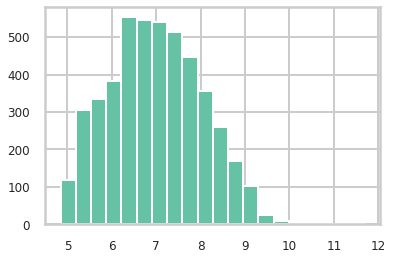

active/non-active ratio 1.827052142488384


In [30]:
import matplotlib.pyplot as plt
plt.hist(df.loc[df.active==1]['VALUE_NUM_mean'], bins=20)
plt.show()
# maybe a cut off point >6.21 is good choice
print('active/non-active ratio',len(df.loc[df.VALUE_NUM_mean>6.21])/len(df.loc[df.VALUE_NUM_mean<=6.21]))

In [31]:
import numpy as np
# create new label with new cut off point.
df['new_active']=np.where(df.VALUE_NUM_mean>6.21,1,0)
df

,compound_id,base_rdkit_smiles,active,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,PXC50,new_active
0,CHEMBL599233,CC(C(=O)c1cccc([N+](=O)[O-])c1)N1CCCCC1,0,5.000000,0.000000,0.000000,0,5.000000,0
1,CHEMBL2047573,OC(CCN1CCC(O)(Cc2ccccc2)CC1)c1ccc(Cl)c(Cl)c1,1,6.249574,0.000738,0.013645,0,6.248721,1
2,CHEMBL1083410,CNC[C@H](O)CCN1c2ccccc2N(c2ccccc2F)S1(=O)=O,0,5.619388,0.001060,0.021791,0,5.618163,0
3,CHEMBL3673162,COc1ccc(-c2ccc3c(c2)CN2CCC3(c3ccc(Cl)c(Cl)c3)C...,1,8.229574,0.000602,0.005177,0,8.229148,1
4,CHEMBL2096860,COC(=O)[C@H]1C2CCC(C[C@@H]1c1ccc(I)cc1)N2C,1,7.642648,0.002293,0.017351,0,7.643974,1
...,...,...,...,...,...,...,...,...,...
5471,CHEMBL218952,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.700000,NaN,0.000000,0,3.700000,0
5472,CHEMBL3143431,CC[C@H](C)[C@H](NC(=O)[C@@H](NC[C@H](CC(C)C)NC...,1,8.100000,NaN,0.000000,0,8.100000,1
5473,CHEMBL411570,C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O...,0,3.740000,NaN,0.000000,0,3.740000,0
5474,CHEMBL383931,C[C@H](NC(=O)[C@@H](N)Cc1ccc(-c2ccc(C[C@H](N)C...,0,3.760000,NaN,0.000000,0,3.760000,0


In [32]:
df.to_csv('df_classification_new_cutoff_label.csv')

# Split

---



In [33]:
working_dir = '/content'

In [35]:
# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['new_active']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = 'df_classification_new_cutoff_label.csv'
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_strategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-08 18:39:14,989 Splitting data by scaffold


number of features: 1024


2021-04-08 18:39:18,902 Dataset split table saved to /df_classification_new_cutoff_label_train_valid_test_scaffold_9458f678-ad73-4176-bc35-41daf31d6fc9.csv


In [37]:
split_uuid = pl.split_dataset()
split_uuid

2021-04-08 18:40:59,491 Splitting data by scaffold


number of features: 1024


2021-04-08 18:41:03,382 Dataset split table saved to /df_classification_new_cutoff_label_train_valid_test_scaffold_4b3e8472-c4fa-449a-99f0-10508f0af9d4.csv


'4b3e8472-c4fa-449a-99f0-10508f0af9d4'

# Train Initial Rf

---



In [38]:
# train inital rf model

response_col = "new_active"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [39]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-08 18:42:17,226 Previous dataset split restored
2021-04-08 18:42:25,064 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/a959a607-7bb5-4ffc-b205-46d76d6422a1/model_metadata.json
2021-04-08 18:42:25,527 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/a959a607-7bb5-4ffc-b205-46d76d6422a1/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_a959a607-7bb5-4ffc-b205-46d76d6422a1.tar.gz


In [41]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.877


In [42]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['roc_auc_score']:.3f}")

R2 score of test set: 0.814


In [43]:
# Adding uncertainty to base training model
# The glob module finds all the pathnames matching a specified pattern according to the rules


params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [44]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-08 18:44:44,111 Previous dataset split restored
2021-04-08 18:44:51,955 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b0ce8c8d-2f6e-4976-9c71-a3d97ef79fc4/model_metadata.json
2021-04-08 18:44:52,413 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b0ce8c8d-2f6e-4976-9c71-a3d97ef79fc4/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_b0ce8c8d-2f6e-4976-9c71-a3d97ef79fc4.tar.gz


In [46]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.875


# Grid Search 1

In [47]:
params

{'data_owner': 'username',
 'dataset_key': 'df_classification_new_cutoff_label.csv',
 'datastore': 'False',
 'featurizer': 'ecfp',
 'id_col': 'compound_id',
 'lc_account': 'None',
 'max_epochs': '70',
 'model_type': 'RF',
 'prediction_type': 'classification',
 'previously_split': 'True',
 'rerun': 'False',
 'response_cols': 'new_active',
 'result_dir': 'ampl_output',
 'save_results': 'False',
 'smiles_col': 'base_rdkit_smiles',
 'split_uuid': '4b3e8472-c4fa-449a-99f0-10508f0af9d4',
 'system': 'LC',
 'transformers': 'True',
 'uncertainty': 'True',
 'verbose': 'True'}

In [ ]:
n_estimator = [100,200,300,400,500]
rf_max_depth = [70,150,200]
rf_max_features = [10,50,100]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['roc_auc_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

In [50]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_roc_score": valid_r2_list})
perf_df.sort_values(by="valid_auc_roc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_auc_roc_score
19,300,70,50,0.878793
29,400,70,100,0.877975
16,200,200,50,0.877567
44,500,200,100,0.877383
31,400,150,50,0.877335
42,500,200,10,0.877280
1,100,70,50,0.876681
27,400,70,10,0.876456
20,300,70,100,0.876122
23,300,150,100,0.875598


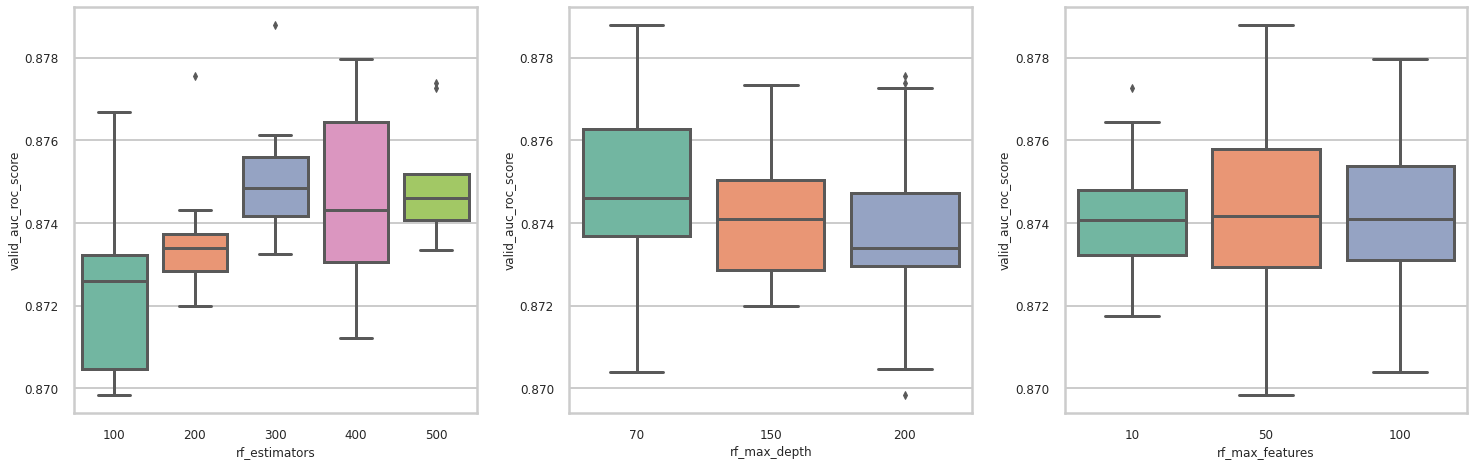

In [51]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_auc_roc_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_auc_roc_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_auc_roc_score", ax=ax[2])
fig.tight_layout()

# Refined Grid Search

In [53]:
#  Retrieve model metadata and performance metrics stored in the filesystem from a hyperparameter search run.
cmp.get_filesystem_perf_results('ampl_output', pred_type='classification').sort_values(by='valid_roc_auc_score', ascending=False)

Found data for 47 models under ampl_output


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_roc_auc_score,train_prc_auc_score,train_precision,train_recall_score,train_num_compounds,train_accuracy_score,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,train_confusion_matrix,valid_roc_auc_score,valid_prc_auc_score,valid_precision,valid_recall_score,valid_num_compounds,valid_accuracy_score,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,valid_confusion_matrix,test_roc_auc_score,test_prc_auc_score,test_precision,test_recall_score,test_num_compounds,test_accuracy_score,test_npv,test_matthews_cc,test_kappa,test_cross_entropy,test_confusion_matrix
41,bde45d42-3474-4ce2-b287-f556f27d37ac,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,300,50,70.0,0.878793,0.997994,0.999010,0.976182,0.988787,4380,0.976256,0.976412,0.945963,0.945778,0.097243,"[[[1366, 71], [33, 2910]]]",0.878793,0.891008,0.776567,0.904762,548,0.795620,0.834254,0.581103,0.569370,0.506293,"[[[151, 82], [30, 285]]]",0.814480,0.829169,0.692308,0.832740,548,0.724453,0.776190,0.455687,0.445597,0.552996,"[[[163, 104], [47, 234]]]"
5,b9ce3d5f-6399-46bd-b49b-fc5fa8fe1e3f,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,400,100,70.0,0.877975,0.997963,0.998994,0.976822,0.988107,4380,0.976256,0.975053,0.945965,0.945816,0.095827,"[[[1368, 69], [35, 2908]]]",0.877975,0.882811,0.775342,0.898413,548,0.791971,0.825137,0.572844,0.562184,0.507919,"[[[151, 82], [32, 283]]]",0.812761,0.830656,0.700000,0.822064,548,0.728102,0.770642,0.460858,0.453350,0.605151,"[[[168, 99], [50, 231]]]"
10,bd7d17ef-f234-4e00-9d58-5a4f2a90d297,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,200,50,200.0,0.877567,0.997913,0.998972,0.976822,0.988107,4380,0.976256,0.975053,0.945965,0.945816,0.097620,"[[[1368, 69], [35, 2908]]]",0.877567,0.887731,0.755319,0.901587,548,0.775547,0.819767,0.539831,0.524614,0.510286,"[[[141, 92], [31, 284]]]",0.817232,0.831077,0.691843,0.814947,548,0.718978,0.760369,0.442463,0.434953,0.549331,"[[[165, 102], [52, 229]]]"
18,17c4c0cf-d86e-47e3-adc9-0c9919f72227,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,100,200.0,0.877383,0.997988,0.999007,0.979075,0.985729,4380,0.976256,0.970360,0.946003,0.945952,0.096057,"[[[1375, 62], [42, 2901]]]",0.877383,0.885173,0.774725,0.895238,548,0.790146,0.820652,0.568747,0.558597,0.510218,"[[[151, 82], [33, 282]]]",0.808596,0.821158,0.682493,0.818505,548,0.711679,0.758294,0.429117,0.419950,0.611779,"[[[160, 107], [51, 230]]]"
26,28c83d35-5c99-4c17-829c-062196b153e0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,400,50,150.0,0.877335,0.998017,0.999021,0.976502,0.988447,4380,0.976256,0.975732,0.945964,0.945797,0.096876,"[[[1367, 70], [34, 2909]]]",0.877335,0.888173,0.771739,0.901587,548,0.790146,0.827778,0.569545,0.557581,0.455876,"[[[149, 84], [31, 284]]]",0.812188,0.827701,0.687316,0.829181,548,0.718978,0.770335,0.444732,0.434529,0.558517,"[[[161, 106], [48, 233]]]"
19,470b6720-f01e-4641-ba5d-7fac1e533056,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,10,200.0,0.877280,0.998027,0.999028,0.977143,0.987768,4380,0.976256,0.974377,0.945967,0.945836,0.101534,"[[[1369, 68], [36, 2907]]]",0.877280,0.882588,0.757979,0.904762,548,0.779197,0.825581,0.547785,0.532344,0.462033,"[[[142, 91], [30, 285]]]",0.813507,0.840395,0.668555,0.839858,548,0.704380,0.769231,0.419332,0.404372,0.554342,"[[[150, 117], [45, 236]]]"
20,84ffe8d7-d9e8-465f-8cbd-94f0fb56db75,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,70.0,0.876681,0.997898,0.998962,0.977143,0.987768,4380,0.

In [57]:
# save the best model
model_class =cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)
model_class.to_csv('best_class_model.csv')

Found data for 47 models under ampl_output


# Test??

---



---




In [ ]:
! pip install molvs

In [ ]:
from atomsci.ddm.pipeline import predict_from_model

In [ ]:
# Test loading model from tarball and running predictions
'''test = predict_from_model.predict_from_model_file(model_path='curated_combined_df_1_model_a450a840-73b9-4581-857c-9ab2568bab7c.tar.gz',
                            input_df = df_avg,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='VALUE_NUM_mean',
                            is_featurized=False,
                            dont_standardize=True)
                            '''

Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.278 s
Loading dataset from disk.


In [ ]:
'''from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))
print(mean_squared_error(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))

'''

0.8277570697289813
0.24862874011036065
